In [1]:
'''
In this notebook we will try to understand which on-game feature is more relevant in order to predict the level of the 
performance of a player in the pitch. This will be useful in order to estimate the level of these important features for 
players who won the league in the last 4 years, so to be able to find comparable players at a lower price.
'''

# Data Load

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
from boruta import BorutaPy
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from feature_engine.selection import SelectByShuffling
from sklearn.feature_selection import SelectKBest, f_regression
from feature_engine.selection import SelectByTargetMeanPerformance
from feature_engine.selection import SelectBySingleFeaturePerformance

players = pd.read_csv("../Datasets/Players Statistics/data_2/Final Datasets/Parametrized/Final_df_players_Parametrized.csv")
keepers = pd.read_csv("../Datasets/Players Statistics/data_2/Final Datasets/Parametrized/Final_df_keepers_Parametrized.csv")

all_data = [players, keepers]

# Null Values

In [3]:
for i in range(len(all_data)):
    list_column = list(all_data[i].columns[list(all_data[i].columns).index("Data_League")+1:])
    all_data[i].loc[:,list_column] = all_data[i].loc[:,list_column].fillna(0.0)
    
keepers.loc[:, "Foot"] = keepers.loc[:, "Foot"].fillna("right") #Sergio Herrera, looked on transfermarkt for preferred foot

# Creation of a dataset per role

In [4]:
posizioni = np.unique(players['Position'])

new_roles = ['Centre-Back', 'Full-Back', 'Midfielder', 'Striker', 'Winger']

role_dictionary = {'Attacking Midfield' : new_roles[2], 
                   'Central Midfield' : new_roles[2], 
                   'Centre-Back' : new_roles[0],
                   'Centre-Forward' : new_roles[3],
                   'Defensive Midfield' : new_roles[2], 
                   'Left Midfield' : new_roles[4],
                   'Left Winger' : new_roles[4], 
                   'Left-Back' : new_roles[1],  
                   'Right Midfield' : new_roles[4], 
                   'Right Winger' : new_roles[4],
                   'Right-Back' : new_roles[1], 
                   'Second Striker' : new_roles[3]}

players['Gen_Pos'] = players['Position'].map(role_dictionary)
Gen_Pos = players.pop('Gen_Pos')
players.insert(6, 'Gen_Pos', Gen_Pos)
keepers['Gen_Pos'] = keepers['Position']

centre_Backs = players[players['Gen_Pos'] == 'Centre-Back'].reset_index().drop(['index'], axis = 1)
full_Backs = players[players['Gen_Pos'] == 'Full-Back'].reset_index().drop(['index'], axis = 1)
midfielders = players[players['Gen_Pos'] == 'Midfielder'].reset_index().drop(['index'], axis = 1)
strikers= players[players['Gen_Pos'] == 'Striker'].reset_index().drop(['index'], axis = 1)
wingers = players[players['Gen_Pos'] == 'Winger'].reset_index().drop(['index'], axis = 1)

# Deletion of columns that won't be used in ML Models

In [5]:
all_data2 = [centre_Backs, full_Backs, midfielders, strikers, wingers, keepers]

for i in range(len(all_data2)):
    all_data2[i].drop(['Player_SN','Player_LN','Player Valuation', 'Age', 'scouting_period',
                       'Position', 'Height', 'Foot', 'Data_League', 'Gen_Pos'], axis = 1, inplace = True)

# Correlation investigation

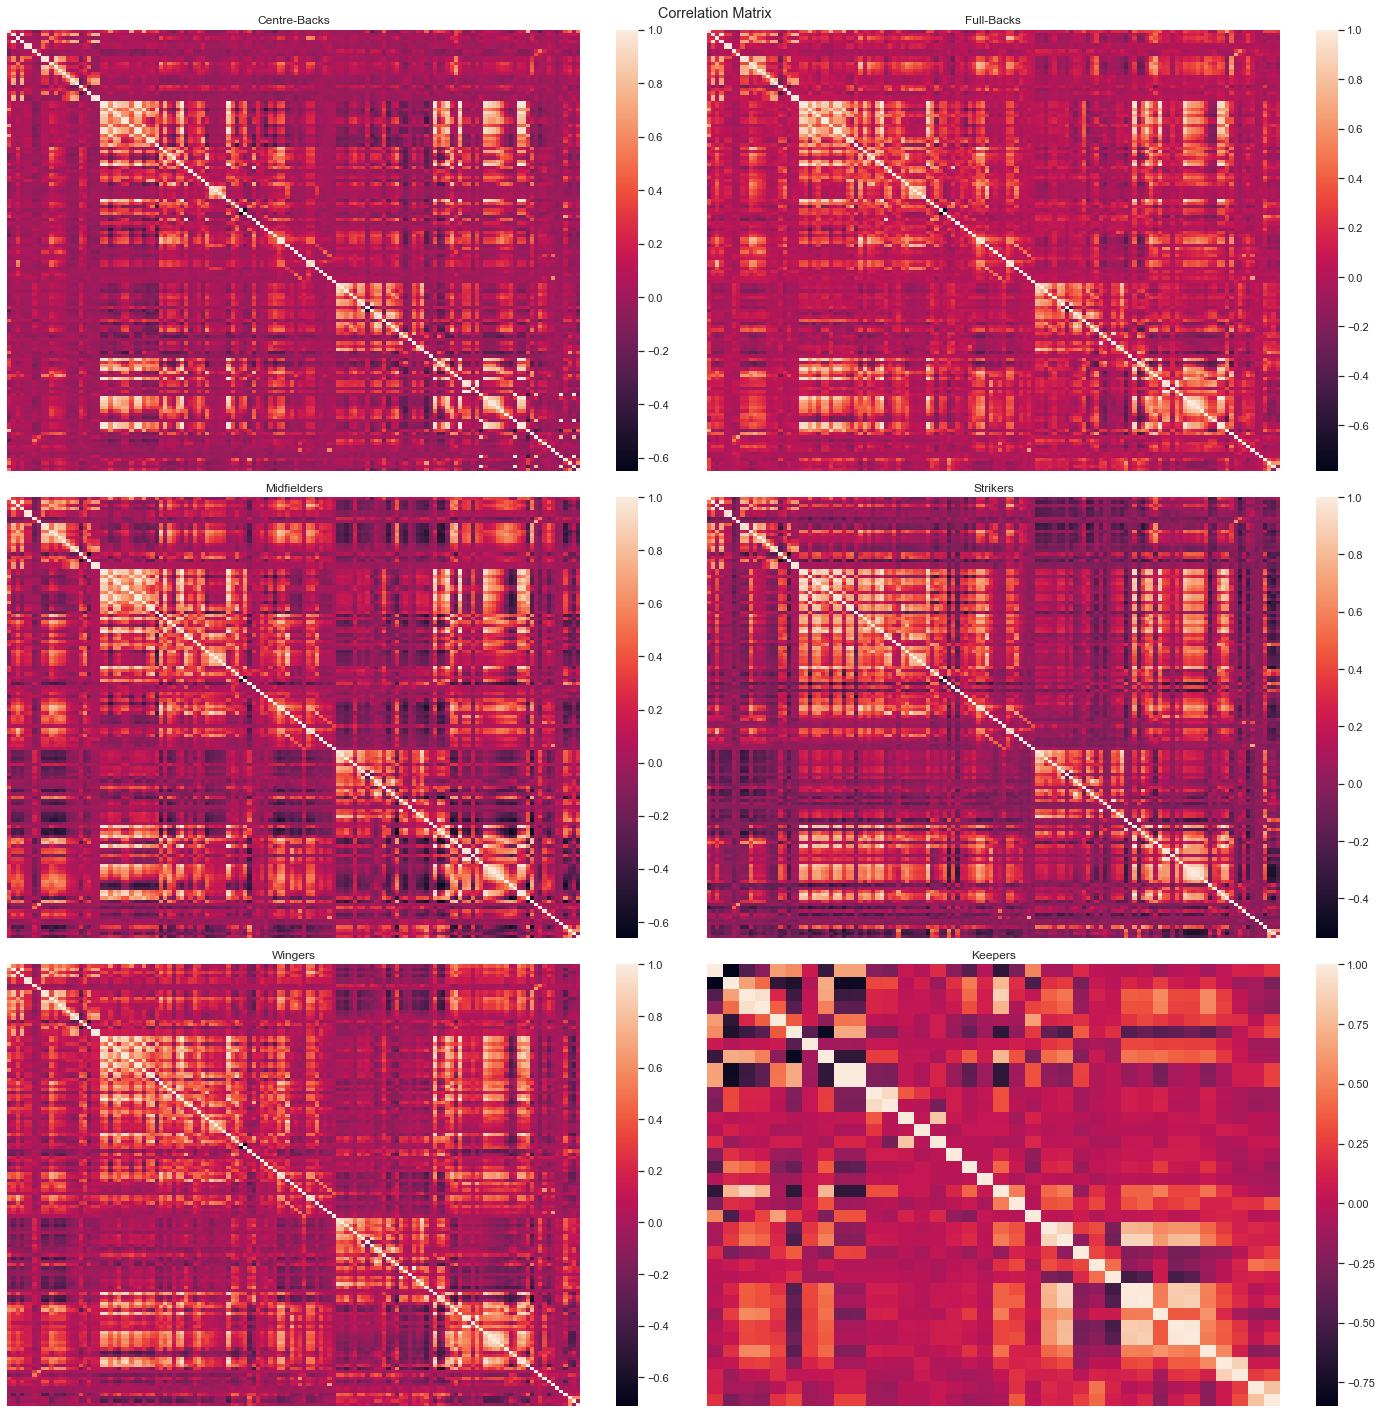

In [6]:
sb.set()

fig, axs = plt.subplots(3, 2, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.suptitle('Correlation Matrix')
a = ['tab:orange']
sb.heatmap(centre_Backs.corr(), ax=axs[0,0], xticklabels=False, yticklabels=False).set(
    title="Centre-Backs")
sb.heatmap(full_Backs.corr(), ax=axs[0,1], xticklabels=False, yticklabels=False).set(
    title="Full-Backs")
sb.heatmap(midfielders.corr(), ax=axs[1,0], xticklabels=False, yticklabels=False).set(
    title="Midfielders")
sb.heatmap(strikers.corr(), ax=axs[1,1], xticklabels=False, yticklabels=False).set(
    title="Strikers")
sb.heatmap(wingers.corr(), ax=axs[2,0], xticklabels=False, yticklabels=False).set(
    title="Wingers")
sb.heatmap(keepers.corr(), ax=axs[2,1], xticklabels=False, yticklabels=False).set(
    title="Keepers")
fig.tight_layout(pad=1.0)

# PCA investigation

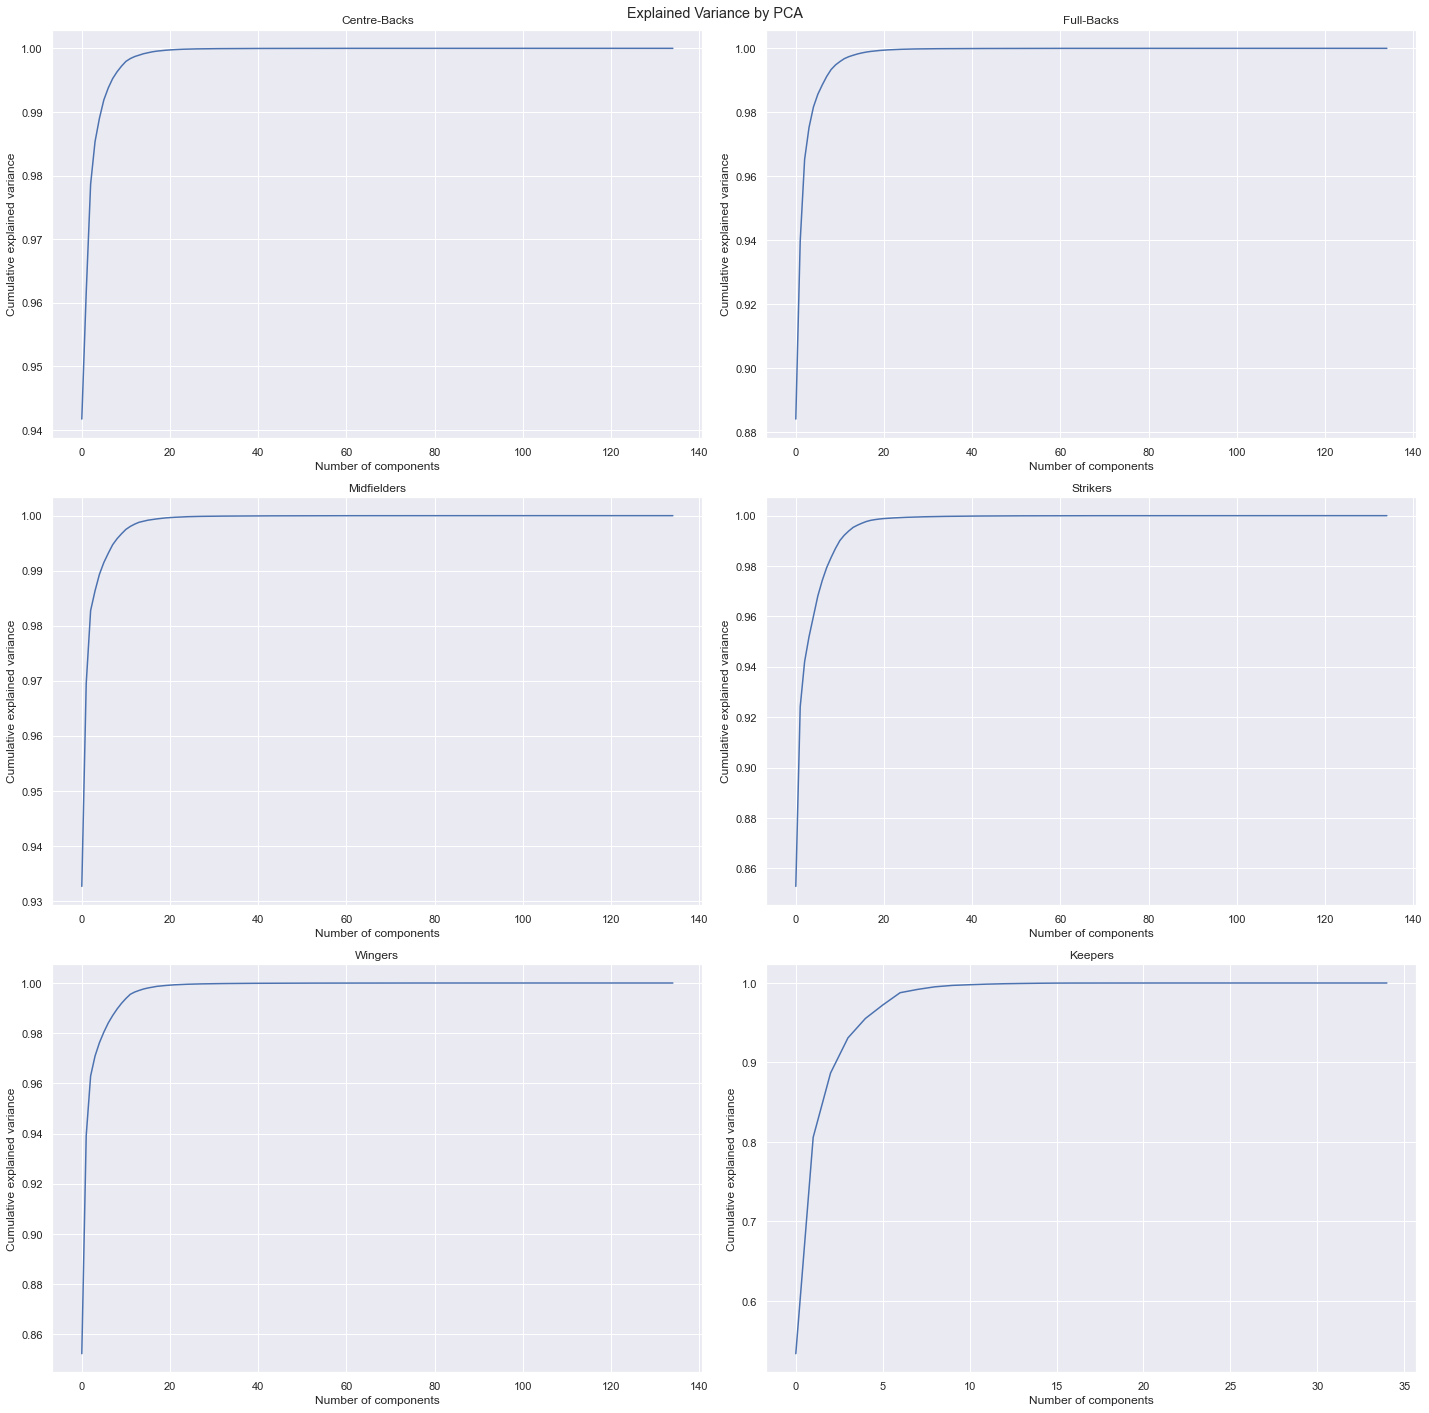

In [7]:
from sklearn.decomposition import PCA

titles = ['Centre-Backs', 'Full-Backs', 'Midfielders', 'Strikers', 'Wingers', 'Keepers']
all_data2 = [centre_Backs, full_Backs, midfielders, strikers, wingers, keepers]

fig, axs = plt.subplots(3, 2, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.suptitle('Explained Variance by PCA')
axs = axs.ravel()
a = ['tab:orange']
for j in range(len(titles)):
    X = all_data2[j].iloc[:, 1:].values
    pca = PCA()
    pca.fit(X)
    axs[j].set_title(f'{titles[j]}')
    axs[j].plot(np.cumsum(pca.explained_variance_ratio_))
    axs[j].set_xlabel('Number of components')
    axs[j].set_ylabel('Cumulative explained variance')
fig.tight_layout(pad=1.0)

In [8]:
titles = ['Centre-Backs', 'Full-Backs', 'Midfielders', 'Strikers', 'Wingers', 'Keepers']

for j in range(len(titles)):
    X = all_data2[j].iloc[:, 1:].values
    pca = PCA()
    pca.fit(X)
    print(f"{titles[j]}, {np.cumsum(pca.explained_variance_ratio_)[:6]}")

Centre-Backs, [0.94172486 0.96159008 0.97865205 0.98532776 0.9890182  0.99189971]
Full-Backs, [0.88410854 0.93974755 0.9652887  0.9752804  0.9816707  0.98565093]
Midfielders, [0.93266203 0.96946962 0.98276325 0.98634254 0.98935702 0.99149425]
Strikers, [0.85284779 0.9241617  0.94208428 0.95195936 0.96016561 0.96816589]
Wingers, [0.85232632 0.93922184 0.96297871 0.97089343 0.9762358  0.98044119]
Keepers, [0.53365164 0.80586724 0.88680468 0.93095997 0.95531496 0.97227784]


In [9]:
'''
With only the first 5 components, we are able to detect more than 95% of the variance for each of the role we decided to
consider during our analysis.
'''

# Variable Selection

In [10]:
'''
To detect the variables to consider for each role, I will make use of seven different approaches:

1 â€” BorutaPy
2 â€” Recursive Feature Elimination (RFE)
3 â€” Univariate Feature Selection
4 â€” Lasso Regression 
5 â€” Feature Shuffling
6 â€” Feature Performance
7 â€” Target Mean Performance

Once all of them will be completed, I will intersect the results of the 7 different approaches to see which are the most
important variables for each approach, in order to make a consistent final choice.
'''

In [11]:
### Let's initialize dictionary of dictionaries that will keep the important variables

dictionary_for_features = {'BorutaPy' : {},
                           'RFE' : {},
                           'UFS' : {},
                           'Lasso' : {},
                           'F_Shuffle' : {},
                           'F_Performance' : {},
                           'TM_Performance' : {},}

### 1 â€” BorutaPy

In [12]:
def Borutapy_function(X_input, y_input):
    
    X = X_input.values
    y = y_input.values
    
    # define random forest regressor, with utilising all cores 
    rf = RandomForestRegressor(n_jobs = -1, 
                              criterion = 'squared_error',
                              random_state = 42)
    
    # define Boruta feature selection method
    feat_selector = BorutaPy(rf, 
                             n_estimators = 'auto', 
                             verbose = 0,
                             random_state = 42)
    
    # find all relevant features - 5 features should be selected
    feat_selector.fit(X, y)
    
    # initialize list that will be returned
    important_features = []
    
    # keep only level 1 features (estimated best)
    for i in range(len(X_input.iloc[:,1:].columns)):
        if feat_selector.ranking_[i] == 1:
            important_features.append(X_input.columns[i])
            
    return important_features

In [13]:
all_data3 = [centre_Backs, full_Backs, midfielders, strikers, wingers, keepers]
roles = ['Centre-Backs', 'Full-Backs', 'Midfielders', 'Strikers', 'Wingers', 'Keepers']

for i in range(len(all_data3)):
    
    print(f"Starting with {roles[i]}")
    
    X_data = all_data3[i].iloc[:,1:]
    y_data = all_data3[i].iloc[:,0]
    
    dictionary_for_features['BorutaPy'][roles[i]] = Borutapy_function(X_data, y_data)

Starting with Centre-Backs
Starting with Full-Backs
Starting with Midfielders
Starting with Strikers
Starting with Wingers
Starting with Keepers


### 2 â€” Recursive Feature Elimination (RFE)

In [14]:
def RFE_function(X_input, y_input):
    
    X = X_input.values
    y = y_input.values
    
    rf = RandomForestRegressor(n_jobs = -1, 
                               criterion = 'squared_error',
                               random_state = 42)

    # Init, fit
    rfecv = RFECV(
        estimator=rf,
        min_features_to_select=10,
        step=5,
        n_jobs=-1,
        scoring="r2",
        cv=5,
    )
    
    rfecv.fit(X, y)
    
    return list(X_input.columns[rfecv.support_])

In [15]:
for i in range(len(all_data3)):
    
    print(f"Starting with {roles[i]}")
    
    X_data = all_data3[i].iloc[:,1:]
    y_data = all_data3[i].iloc[:,0]
    
    dictionary_for_features['RFE'][roles[i]] = RFE_function(X_data, y_data)

Starting with Centre-Backs
Starting with Full-Backs
Starting with Midfielders
Starting with Strikers
Starting with Wingers
Starting with Keepers


### 3 â€” Univariate Feature Selection

In [16]:
def UFS_function(X_input, y_input):
    
    X = X_input.values
    y = y_input.values
    
    kbest = SelectKBest(score_func = f_regression) 
    pipel = Pipeline([('kbest', kbest), ('rf', RandomForestRegressor(n_jobs = -1,
                                                                     criterion = 'squared_error',
                                                                     random_state = 42))])
    grid_search = GridSearchCV(pipel, 
                               {'kbest__k': [10,11,12,13,14,15,16,17,18,19,20]}) 
    grid_search.fit(X, y) 
    
    selector = SelectKBest(score_func = f_regression, k = grid_search.best_params_['kbest__k'])
    selector.fit_transform(X, y)
    
    return(list(X_input.columns.values[selector.get_support()]))

In [17]:
for i in range(len(all_data3)):
    
    print(f"Starting with {roles[i]}")
    
    X_data = all_data3[i].iloc[:,1:]
    y_data = all_data3[i].iloc[:,0]
    
    dictionary_for_features['UFS'][roles[i]] = UFS_function(X_data, y_data)

Starting with Centre-Backs
Starting with Full-Backs
Starting with Midfielders
Starting with Strikers
Starting with Wingers
Starting with Keepers


### 4 â€” Lasso Regression 

In [18]:
def Lasso_function(X_input, y_input):
    
    X = X_input.values
    y = y_input.values
    
    pipeline = Pipeline([('model',Lasso(max_iter = 10000))])
    
    search = GridSearchCV(pipeline,
                          {'model__alpha':np.arange(0.001,0.1,0.001)},
                          cv = 5, scoring="neg_mean_squared_error"
                          )
    
    search.fit(X,y)
    
    coefficients = search.best_estimator_.named_steps['model'].coef_
    importance = np.abs(coefficients)
    features = X_input.columns
    
    return(list(np.array(features)[importance > 0]))

In [19]:
for i in range(len(all_data3)):
    
    print(f"Starting with {roles[i]}")
    
    X_data = all_data3[i].iloc[:,1:]
    y_data = all_data3[i].iloc[:,0]
    
    dictionary_for_features['Lasso'][roles[i]] = Lasso_function(X_data, y_data)

Starting with Centre-Backs
Starting with Full-Backs
Starting with Midfielders
Starting with Strikers
Starting with Wingers
Starting with Keepers


### 5 â€” Feature Shuffling

In [20]:
def FS_function(X_input, y_input):
          
    X = X_input.values
    y = y_input.values
    
    # initialize linear regression estimator
    model = RandomForestRegressor(n_jobs = -1,
                                  criterion = 'squared_error',
                                  random_state = 42)

    # initialize the feature selector
    tr = SelectByShuffling(estimator=model, scoring="neg_mean_squared_error", cv=5)
    
    # fit transformer
    tr.fit(X, y)
    
    ordered = {k: v for k, v in sorted(tr.performance_drifts_.items(), key=lambda item: item[1], reverse = True)}
    chosen = []
    
    for k in range(20):
        chosen.append(X_input.columns[int(list(ordered.keys())[k])])
                
    return(chosen)

In [21]:
for i in range(len(all_data3)):
    
    print(f"Starting with {roles[i]}")
    
    X_data = all_data3[i].iloc[:,1:]
    y_data = all_data3[i].iloc[:,0]
    
    dictionary_for_features['F_Shuffle'][roles[i]] = FS_function(X_data, y_data)

Starting with Centre-Backs
Starting with Full-Backs
Starting with Midfielders
Starting with Strikers
Starting with Wingers
Starting with Keepers


### 6 â€” Feature Performance

In [22]:
def FP_function(X_input, y_input):
        
    X = X_input.values
    y = y_input.values
    
    # initialize linear regression estimator
    model = RandomForestRegressor(n_jobs = -1,
                                  criterion = 'squared_error',
                                  random_state = 42)
    
    # initialize the feature selector
    sel = SelectBySingleFeaturePerformance(estimator = model,
                                           scoring = "neg_mean_squared_error",
                                           cv = 5)
    
    # fit transformer
    sel.fit(X, y)
    
    ordered = {k: v for k, v in sorted(sel.feature_performance_.items(), key=lambda item: item[1], reverse = True)}
    chosen = []
    
    for k in range(20):
        chosen.append(X_input.columns[int(list(ordered.keys())[k])])
                    
    return(chosen)

In [23]:
for i in range(len(all_data3)):
    
    print(f"Starting with {roles[i]}")
    
    X_data = all_data3[i].iloc[:,1:]
    y_data = all_data3[i].iloc[:,0]
    
    dictionary_for_features['F_Performance'][roles[i]] = FP_function(X_data, y_data)

Starting with Centre-Backs
Starting with Full-Backs
Starting with Midfielders
Starting with Strikers
Starting with Wingers
Starting with Keepers


### 7 â€” Target Mean Performance

In [24]:
def TMP_function(X_input, y_input):
        
    X = X_input.values
    y = y_input.values
    
    tmp = SelectByTargetMeanPerformance(variables = None,
                                        scoring = "neg_mean_squared_error",
                                        bins = 3,
                                        strategy = "equal_frequency",
                                        cv = 5,
                                        regression = True)
    # fit transformer
    tmp.fit(X, y)
    
    ordered = {k: v for k, v in sorted(tmp.feature_performance_.items(), key=lambda item: item[1], reverse = True)}
    chosen = []
    
    for k in range(20):
        chosen.append(X_input.columns[int(list(ordered.keys())[k])])
                    
    return(chosen)

In [25]:
for i in range(len(all_data3)):

    print(f"Starting with {roles[i]}")
    
    X_data = all_data3[i].iloc[:,1:]
    y_data = all_data3[i].iloc[:,0]
    
    dictionary_for_features['TM_Performance'][roles[i]] = TMP_function(X_data, y_data)

Starting with Centre-Backs
Starting with Full-Backs
Starting with Midfielders
Starting with Strikers
Starting with Wingers
Starting with Keepers


# Combination of results

In [26]:
modelli_tried = list(dictionary_for_features.keys())
roles = ['Centre-Backs', 'Full-Backs', 'Midfielders', 'Strikers', 'Wingers', 'Keepers']
final_dictionary = {}

for k in range(len(roles)):
    final_dictionary[roles[k]] = []
    j = []
    for i in range(len(modelli_tried)):
        j.append(dictionary_for_features[modelli_tried[i]][roles[k]])
    j = [item for sublist in j for item in sublist]
    conto = Counter(j)
    for l,m in conto.items():
        if m >= 5: #Here, we require that the variable is present in at least 6 out of the 7 models
            final_dictionary[roles[k]] += [l]
            
### Let's compute similarity
import math

def cosine_sim(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

role_similarity = []

for k in range(len(roles)):
    if roles[k] == "Keepers":
        role_similarity.append([roles[k],"None", 0.0])
    else:
        most_similar = []
        lista = [i for i in roles if i != roles[k]]
        for v in range(len(lista)):
            most_similar.append(cosine_sim(Counter(final_dictionary[roles[k]]),Counter(final_dictionary[lista[v]])))
        role_similarity.append([roles[k],lista[most_similar.index(max(most_similar))], max(most_similar)])
            
for l,m in final_dictionary.items():
    print(f"Role: {l}, Chosen variables: {len(m)}, Most Similar: {[i[1] for i in role_similarity if i[0] == l][0]} (Cosine Similarity = {[i[2] for i in role_similarity if i[0] == l][0]})")

Role: Centre-Backs, Chosen variables: 12, Most Similar: Full-Backs (Cosine Similarity = 0.4811252243246881)
Role: Full-Backs, Chosen variables: 9, Most Similar: Midfielders (Cosine Similarity = 0.7035264706814485)
Role: Midfielders, Chosen variables: 11, Most Similar: Full-Backs (Cosine Similarity = 0.7035264706814485)
Role: Strikers, Chosen variables: 18, Most Similar: Wingers (Cosine Similarity = 0.8249579113843055)
Role: Wingers, Chosen variables: 16, Most Similar: Strikers (Cosine Similarity = 0.8249579113843055)
Role: Keepers, Chosen variables: 8, Most Similar: None (Cosine Similarity = 0.0)


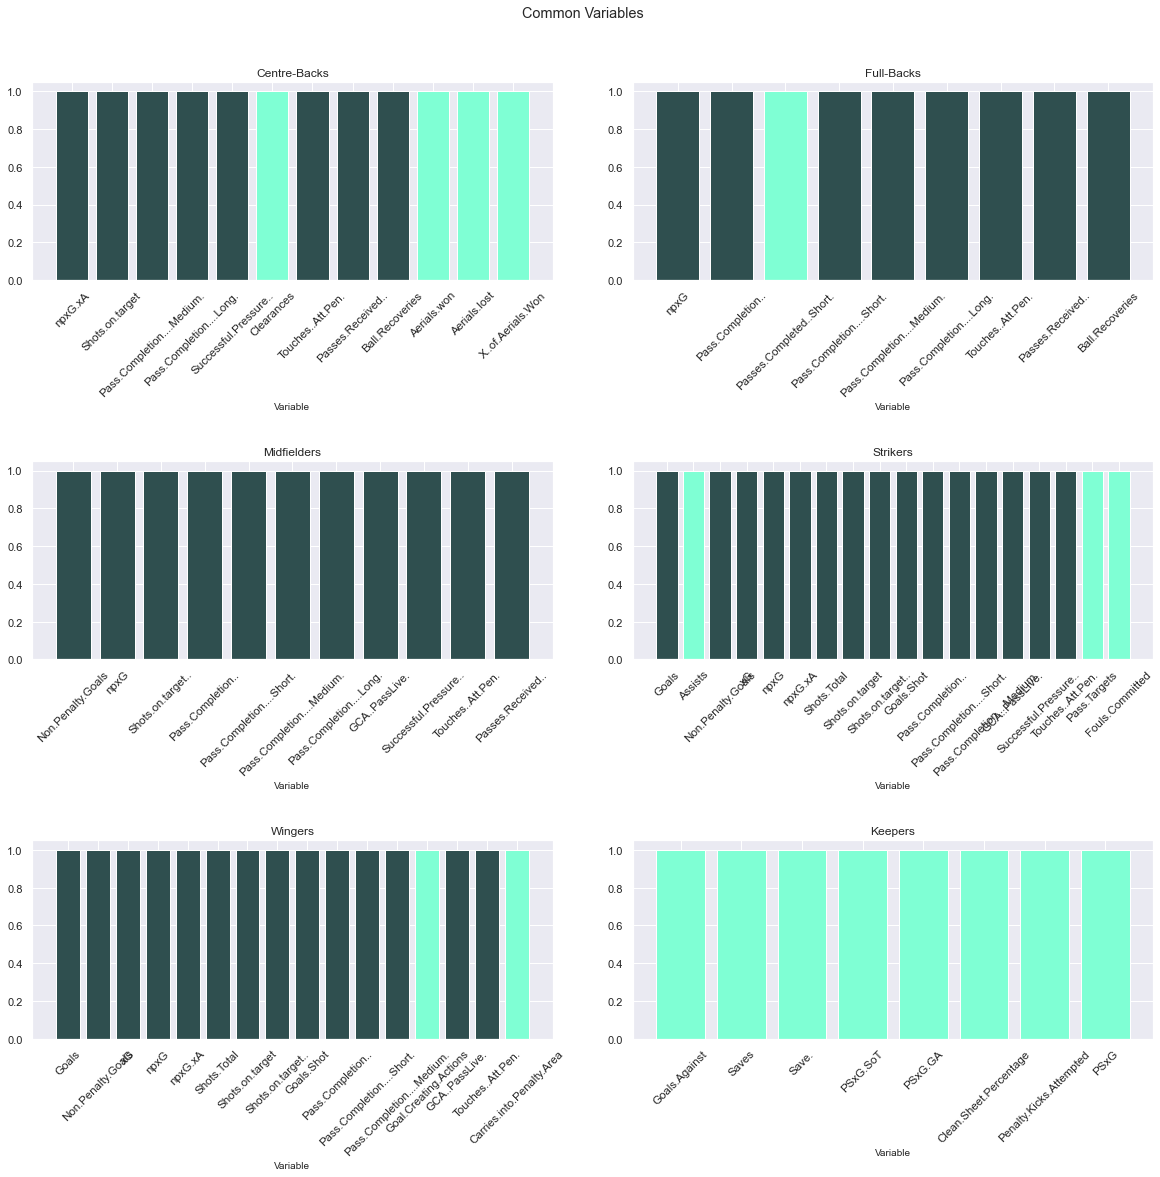

In [27]:
common_keys = []
for j in final_dictionary.values():
    common_keys.append(j)
    
common_keys = [item for sublist in common_keys for item in sublist]
        
d = [(i,common_keys.count(i)) for i in common_keys]

COMUNI = [list(set(d))[i][0] for i in range(len(list(set(d)))) if list(set(d))[i][1] > 1]

colors1 = [[] for i in range(len(list(final_dictionary.keys())))]

for j in range(len(list(final_dictionary.keys()))):
    for k in final_dictionary[list(final_dictionary.keys())[j]]:
        if k in COMUNI:
            colors1[j].append('darkslategray')
        else:
            colors1[j].append('aquamarine')

fig, axs = plt.subplots(3, 2, figsize=(17, 17), facecolor='w', edgecolor='k')
fig.suptitle('Common Variables')
axs = axs.ravel()
a = ['tab:orange']
for j in range(len(list(final_dictionary.keys()))):
    axs[j].set_title(f'{list(final_dictionary.keys())[j]}')
    axs[j].bar(final_dictionary[list(final_dictionary.keys())[j]],1, color = colors1[j])
    axs[j].set_xlabel('Variable',fontsize=10) 
    axs[j].set_xticklabels(final_dictionary[list(final_dictionary.keys())[j]], fontsize=11.5, rotation = 45) 
fig.tight_layout(pad=3.0)